In [ ]:
# --- 1. IMPORT LIBRARIES ---
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd



C:\Users\aryav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 2. FUNGSI SCRAPING & CLEANING ---
def scrape_kompas(max_pages=5):
    """Mengambil judul dan kategori berita dari indeks Kompas.com"""
    print(f"--- Memulai Scraping {max_pages} halaman dari Kompas.com ---")
    data = []
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    for page in range(1, max_pages + 1):
        url = f"https://indeks.kompas.com/?page={page}"
        try:
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')
            articles = soup.find_all('div', class_='articleItem')
            
            for article in articles:
                title_tag = article.find('h2', class_='articleTitle')
                cat_tag = article.find('div', class_='articlePost-subtitle')
                
                if title_tag:
                    title = title_tag.text.strip()
                    category = cat_tag.text.strip() if cat_tag else "General"
                    data.append({'judul': title, 'kategori': category})
            
            print(f"Halaman {page} selesai... ({len(articles)} artikel)")
        except Exception as e:
            print(f"Error di halaman {page}: {e}")

    df = pd.DataFrame(data)
    print(f"--- Scraping Selesai! Total didapatkan {len(df)} artikel ---")
    return df

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # Hapus angka/tanda baca
    text = text.strip()
    return text

def remove_stopwords(text):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    return stopword.remove(text)

--- Memulai Scraping 100 halaman dari Kompas.com ---
Halaman 1 selesai... (20 artikel)
Halaman 2 selesai... (20 artikel)
Halaman 3 selesai... (20 artikel)
Halaman 4 selesai... (20 artikel)
Halaman 5 selesai... (20 artikel)
Halaman 6 selesai... (20 artikel)
Halaman 7 selesai... (20 artikel)
Halaman 8 selesai... (20 artikel)
Halaman 9 selesai... (20 artikel)
Halaman 10 selesai... (20 artikel)
Halaman 11 selesai... (20 artikel)
Halaman 12 selesai... (20 artikel)
Halaman 13 selesai... (20 artikel)
Halaman 14 selesai... (20 artikel)
Halaman 15 selesai... (20 artikel)
Halaman 16 selesai... (20 artikel)
Halaman 17 selesai... (20 artikel)
Halaman 18 selesai... (20 artikel)
Halaman 19 selesai... (20 artikel)
Halaman 20 selesai... (20 artikel)
Halaman 21 selesai... (20 artikel)
Halaman 22 selesai... (20 artikel)
Halaman 23 selesai... (20 artikel)
Halaman 24 selesai... (20 artikel)
Halaman 25 selesai... (20 artikel)
Halaman 26 selesai... (20 artikel)
Halaman 27 selesai... (20 artikel)
Halaman 28 

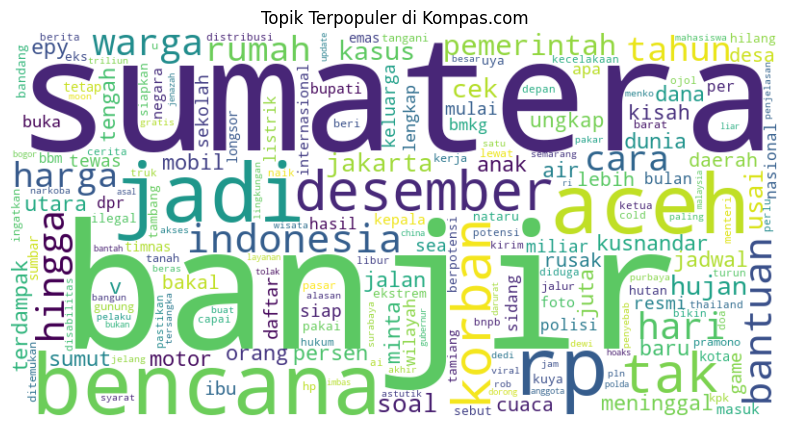


[3/6] Mengubah Teks ke Angka menggunakan AI (BERT)...


Batches: 100%|██████████| 36/36 [00:09<00:00,  3.72it/s]


[4/6] Melakukan Clustering Berita...

[5/6] Menganalisis Topik per Cluster...

--- CLUSTER 0 (Total: 320 artikel) ---
Kata Kunci: kusnandar, epy, tak, meninggal, jadi, kasus, anak
Contoh Berita:
 - Hakim: Meski Tahu Ada Upaya Suap, Djuyamto Tak Lapor MA Layaknya Hakim Berintegritas
 - Kumpulan Hadits Keutamaan Melaksanakan Shalat Jenazah
 - Bagaimana Hukum Menunda Mandi Wajib, Boleh atau Tidak? Ini Penjelasan Sesuai Hadits Rasulullah SAW

--- CLUSTER 1 (Total: 250 artikel) ---
Kata Kunci: warga, tak, hari, jadi, rp, jalan, indonesia
Contoh Berita:
 - Eks Kepala SMKN 1 Ponorogo: Saya Dipojokkan Kegiatan Komite Sekolah yang Saya Tidak Tahu
 - Penyaluran Bantuan ke Wilayah Terisolasi Dievaluasi
 - Doa dan Panduan Islam untuk Mengatasi Stres dan Kecemasan: Mencapai Ketentraman Hati

--- CLUSTER 2 (Total: 254 artikel) ---
Kata Kunci: desember, rp, harga, cek, cara, motor, jadwal
Contoh Berita:
 - Wakapolri Kunjungi Aceh Tamiang, Perintahkan Percepatan Distribusi Logistik
 - BGN Buka Peluang

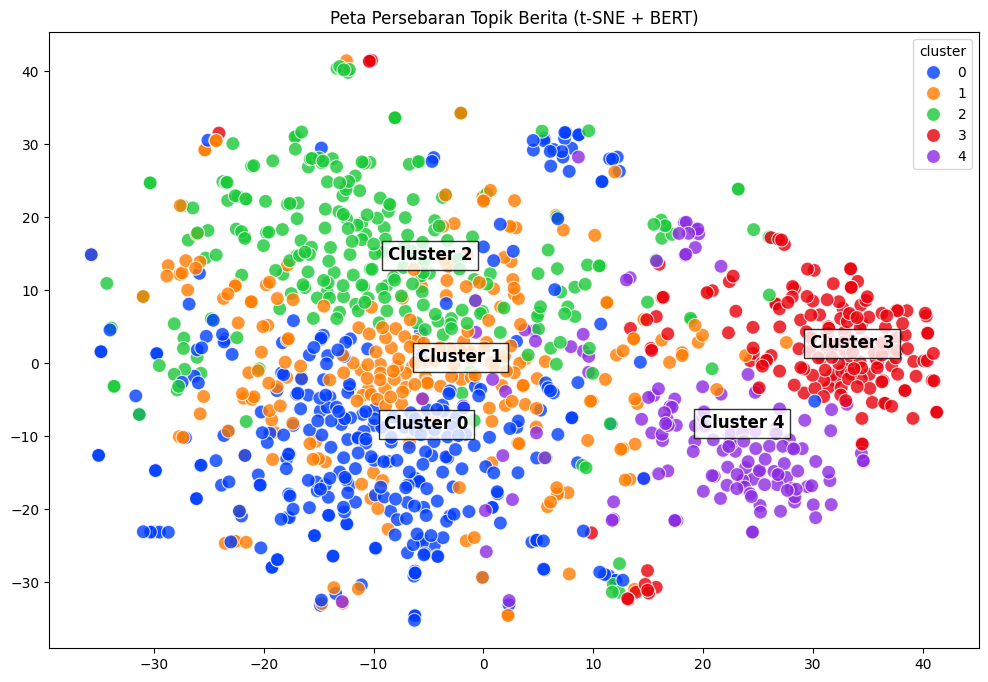

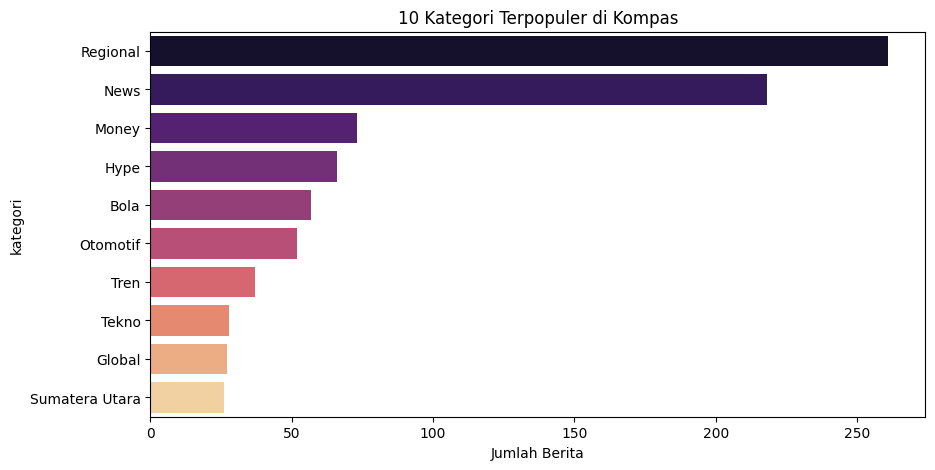

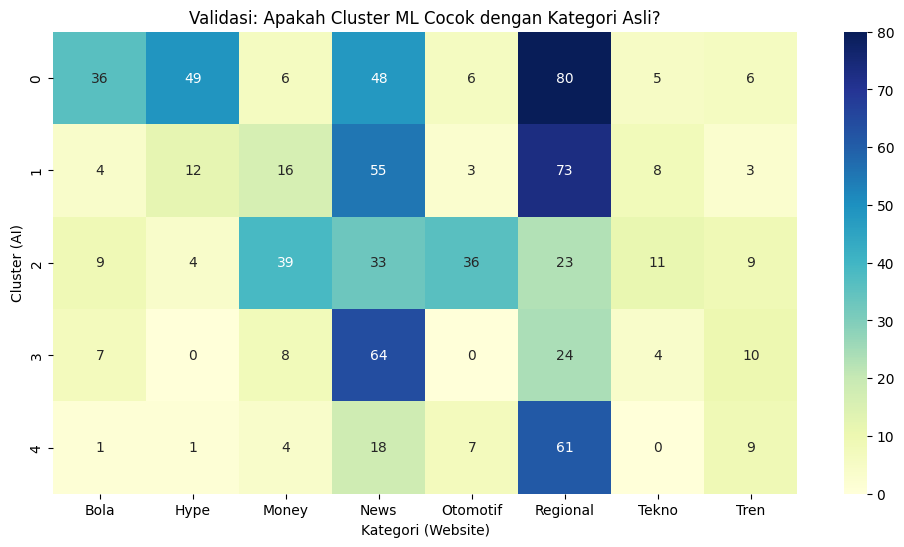

In [ ]:
# --- EKSEKUSI UTAMA ---

# 1. Jalankan Scraping
# Disarankan minimal 5-10 halaman agar data cukup untuk dilatih
df_berita = scrape_kompas(max_pages=100)

if not df_berita.empty:
    
    # --- A. CLEANING DATA ---
    print("\n[1/6] Memulai Pembersihan Data...")
    df_berita['clean_judul'] = df_berita['judul'].apply(clean_text)
    df_berita['clean_judul'] = df_berita['clean_judul'].apply(remove_stopwords)
    df_berita['kategori'] = df_berita['kategori'].str.strip() # Hapus spasi berlebih
    
    # --- B. WORDCLOUD ---
    print("[2/6] Membuat WordCloud...")
    text_combined = ' '.join(df_berita['clean_judul'])
    if len(text_combined) > 0:
        wordcloud = WordCloud(
            width=800, height=400, 
            background_color='white', 
            colormap='viridis', 
            collocations=False
        ).generate(text_combined)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Topik Terpopuler di Kompas.com")
        plt.show()
    
    # --- C. AI ENCODING (BERT) ---
    print("\n[3/6] Mengubah Teks ke Angka menggunakan AI (BERT)...")
    # Load model bahasa Indonesia/Multilingual
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    embeddings = model.encode(df_berita['judul'].tolist(), show_progress_bar=True)
    
    # --- D. CLUSTERING (K-Means) ---
    print("[4/6] Melakukan Clustering Berita...")
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    df_berita['cluster'] = kmeans.labels_
    
    # --- E. ANALISIS ISI CLUSTER ---
    print("\n[5/6] Menganalisis Topik per Cluster...")
    
    # Menggunakan TF-IDF khusus untuk mencari kata kunci di dalam cluster yang terbentuk
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    
    for i in range(num_clusters):
        print(f"\n--- CLUSTER {i} (Total: {len(df_berita[df_berita['cluster']==i])} artikel) ---")
        
        # Ambil data pada cluster ini
        cluster_data = df_berita[df_berita['cluster'] == i]
        
        # 1. Tampilkan Kata Kunci Dominan (TF-IDF per cluster)
        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_data['clean_judul'])
            feature_names = tfidf_vectorizer.get_feature_names_out()
            # Sum TF-IDF untuk setiap kata, lalu urutkan
            sums = tfidf_matrix.sum(axis=0)
            data = []
            for col, term in enumerate(feature_names):
                data.append((term, sums[0, col]))
            ranking = pd.DataFrame(data, columns=['term', 'rank'])
            top_words = ranking.sort_values('rank', ascending=False).head(7)['term'].tolist()
            print(f"Kata Kunci: {', '.join(top_words)}")
        except ValueError:
            print("Kata Kunci: (Data terlalu sedikit untuk diekstraksi)")

        # 2. Tampilkan Contoh Judul
        print("Contoh Berita:")
        for judul in cluster_data['judul'].head(3).values:
            print(f" - {judul}")

    # --- F. VISUALISASI DATA ---
    print("\n[6/6] Membuat Visualisasi Akhir...")
    
    # 1. Reduksi Dimensi (t-SNE) untuk Scatter Plot
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df_berita)-1))
    scatter_points = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=scatter_points[:, 0], y=scatter_points[:, 1],
        hue=df_berita['cluster'], palette='bright', 
        s=100, alpha=0.8, legend='full'
    )
    
    # Menambahkan label judul berita pada pusat cluster (opsional)
    for i in range(num_clusters):
        cluster_points = scatter_points[df_berita['cluster'] == i]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
            plt.text(centroid[0], centroid[1], f"Cluster {i}", 
                     fontsize=12, weight='bold', 
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
            
    plt.title("Peta Persebaran Topik Berita (t-SNE + BERT)")
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

    # 2. Bar Chart Kategori Asli
    plt.figure(figsize=(10, 5))
    top_kategori = df_berita['kategori'].value_counts().head(10)
    sns.barplot(x=top_kategori.values, y=top_kategori.index, hue=top_kategori.index, palette='magma', legend=False)
    plt.title('10 Kategori Terpopuler di Kompas')
    plt.xlabel('Jumlah Berita')
    plt.show()

    # 3. Heatmap (Validasi Cluster vs Kategori)
    # Filter hanya kategori besar agar grafik terbaca
    kategori_utama = df_berita['kategori'].value_counts().head(8).index
    df_filtered = df_berita[df_berita['kategori'].isin(kategori_utama)]
    
    cross_tab = pd.crosstab(df_filtered['cluster'], df_filtered['kategori'])
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Validasi: Apakah Cluster ML Cocok dengan Kategori Asli?')
    plt.ylabel('Cluster (AI)')
    plt.xlabel('Kategori (Website)')
    plt.show()

else:
    print("Gagal mengambil data. Cek koneksi internet atau struktur HTML Kompas.com.")